## **Check GPU**

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3060 Ti (UUID: GPU-981912e7-585f-49c2-1ad9-600372b88670)


In [2]:
# Check TensorFlow version (should be minimum 2.4.0+ but 2.13.0+ is better)
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

# Add timestamp
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

TensorFlow version: 2.14.0-dev20230620
Notebook last run (end-to-end): 2023-07-22 16:31:00.590941


## **Get helper functions**

In [3]:
# Get helper functions file
import os

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")


[INFO] 'helper_functions.py' already exists, skipping download.


## **Download Kaggle dataset**

In [4]:
import opendatasets as od
import pandas as pd

In [5]:
# Download data from Kaggle
od.download("https://www.kaggle.com/datasets/saloni1712/chatgpt-app-reviews")

Skipping, found downloaded files in ".\chatgpt-app-reviews" (use force=True to force download)


In [6]:
data = pd.read_csv('C:/Users/Nima/Desktop/ChatGPT_Reviews/chatgpt-app-reviews/chatgpt_reviews.csv')

In [7]:
data.shape

(2058, 4)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2058 entries, 0 to 2057
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    2058 non-null   object
 1   title   2058 non-null   object
 2   review  2058 non-null   object
 3   rating  2058 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 64.4+ KB


In [9]:
data.describe()

,rating
count,2058.000000
mean,3.744898
std,1.577841
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


In [10]:
data.describe(include='object')

,date,title,review
count,2058,2058,2058
unique,2053,1850,2033
top,2023-05-18 23:04:43,Finally,First
freq,2,13,5


## **Analysis of Rating column**

In [11]:
#Rating Distribution
data['rating'].value_counts().sort_index()

1     391
2     115
3     199
4     276
5    1077
Name: rating, dtype: int64

In [12]:
data['rating'].value_counts(normalize=True).mul(100).round(2).sort_index()

1    19.00
2     5.59
3     9.67
4    13.41
5    52.33
Name: rating, dtype: float64

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

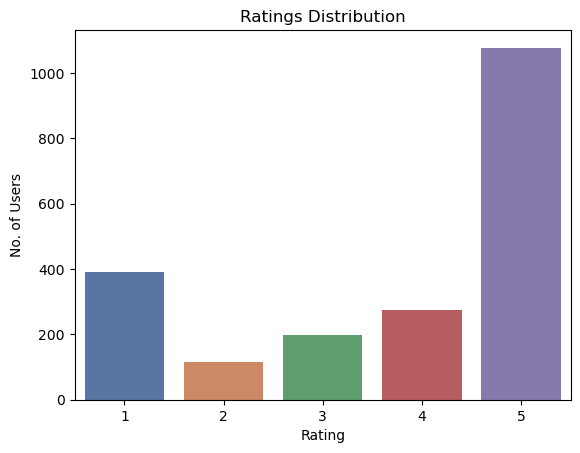

In [14]:
#Plot
palette = "deep"
sns.set_palette(palette)

sns.countplot(data=data, x='rating')

plt.xlabel('Rating')
plt.ylabel('No. of Users')
plt.title('Ratings Distribution')

plt.show()

## **Data Preprocessing**

In [15]:
#Find no. of missing values in each column
data.isnull().sum().sort_values(ascending=False)

date      0
title     0
review    0
rating    0
dtype: int64

In [16]:
#Combine Review Time and Review
data['complete_review'] = data['title'] +' .'+data['review']

In [17]:
#Drop some columns which we won't use for sentiment analysis of review
remove_cols = ['date','review','title']
data = data.drop(remove_cols,axis='columns')

In [18]:
data.head()

,rating,complete_review
0,4,Much more accessible for blind users than the ...
1,4,"4.5 stars, here’s why .I recently downloaded t..."
2,4,"Almost 5 stars, but… no search function .This ..."
3,4,"Good, but Siri support would take it to the ne..."
4,1,"App review .No doubt, this technology is absol..."


#### **Convert all the reviews to lowercase**

In [19]:
data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['complete_review'].head()

0    much more accessible for blind users than the ...
1    4.5 stars, here’s why .i recently downloaded t...
2    almost 5 stars, but… no search function .this ...
3    good, but siri support would take it to the ne...
4    app review .no doubt, this technology is absol...
Name: complete_review, dtype: object

#### **Remove Punctuation**

In [20]:
data['complete_review'] = data['complete_review'].str.replace('[^\w\s]','')

C:\Users\Nima\AppData\Local\Temp\ipykernel_27760\3606737599.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data['complete_review'] = data['complete_review'].str.replace('[^\w\s]','')


#### **Remove Emojis**

In [21]:
import re

In [22]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
data['complete_review'] = data['complete_review'].apply(lambda x: remove_emoji(x))

#### **Remove Stopwords**

In [23]:
# Instal spaCy: https://spacy.io/usage
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm

  Using cached pip-23.2.1-py3-none-any.whl (2.1 MB)
  Using cached setuptools-68.0.0-py3-none-any.whl (804 kB)
  Using cached wheel-0.41.0-py3-none-any.whl (64 kB)


ERROR: To modify pip, please run the following command:
C:\Users\Nima\anaconda3\envs\tensorflow_python_3_10\python.exe -m pip install -U pip setuptools wheel


                                              0.0/12.8 MB ? eta -:--:--
                                              0.0/12.8 MB ? eta -:--:--
                                              0.2/12.8 MB 2.3 MB/s eta 0:00:06
                                              0.2/12.8 MB 2.0 MB/s eta 0:00:07
     -                                        0.3/12.8 MB 1.9 MB/s eta 0:00:07
     -                                        0.5/12.8 MB 2.2 MB/s eta 0:00:06
     -                                        0.6/12.8 MB 2.0 MB/s eta 0:00:07
     --                                       0.7/12.8 MB 2.2 MB/s eta 0:00:06
     --                                       0.8/12.8 MB 2.2 MB/s eta 0:00:06
     --                                       0.9/12.8 MB 2.3 MB/s eta 0:00:06
     ---                                      1.1/12.8 MB 2.4 MB/s eta 0:00:05
     ---                                      1.2/12.8 MB 2.4 MB/s eta 0:00:05
     ----                                     1.3/12.8 MB 2.5 MB/s

In [24]:
import nltk
from nltk.corpus import stopwords
import spacy

In [25]:
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nima\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
# nlp = spacy.load('en_core_web_sm')

In [27]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [28]:
stop = stopwords.words('english')
data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

#### **Apply Lemmatization**

In [29]:
def space(comment):
    doc = nlp(comment)
    return " ".join([token.lemma_ for token in doc])
data['complete_review']= data['complete_review'].apply(space)

#### **Remove certain words**

In [30]:
words_to_remove = ['chatgpt','app','chatgpts','chat','gpt','iphone','ipad','gpt4','phone','number','ai','use','io']
data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x for x in x.split() if x not in words_to_remove))

#### **Map ratings to positive, negative & neutral sentiment**

0 will represent negative sentiment

1 will represent neutral sentiment

2 will represent positive sentiment

In [31]:
data['sentiment'] = data['rating'].apply(lambda rating: 2 if rating > 3 else (1 if rating == 3 else 0))
data.head(5)

,rating,complete_review,sentiment
0,4,much accessible blind user web version point I...,2
1,4,45 star here recently download overall great p...,2
2,4,almost 5 star search function would almost per...,2
3,4,good siri support would take next level apprec...,2
4,1,review doubt technology absolutely lifechange ...,0


In [32]:
data['sentiment'].value_counts(normalize=True).mul(100).round(2)

2    65.74
0    24.59
1     9.67
Name: sentiment, dtype: float64

## **Reviews Analysis**

In [33]:
!pip install wordcloud

In [34]:
from wordcloud import WordCloud, STOPWORDS

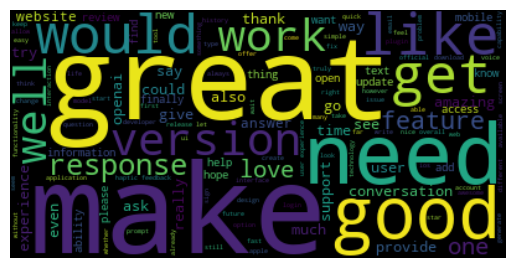

In [35]:
#Analysis of Review field
stopword = set(stopwords.words('english'))
text = " ".join(review for review in data.complete_review)
wordcloud = WordCloud(stopwords=stopword).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [36]:
#positive negative & neutral sentiment:
positive = data[data['sentiment'] == 2]
negative = data[data['sentiment'] == 0]
neutral = data[data['sentiment'] == 1]

In [37]:
positive.shape, negative.shape, neutral.shape

((1353, 3), (506, 3), (199, 3))

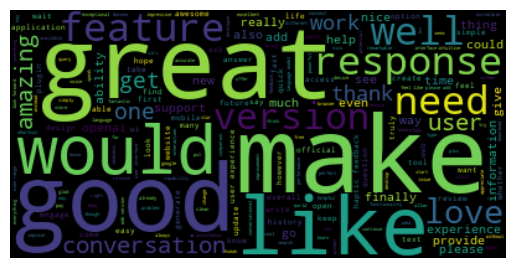

In [38]:
#Positive Setiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in positive.complete_review)
wordcloud = WordCloud(stopwords=stopword).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

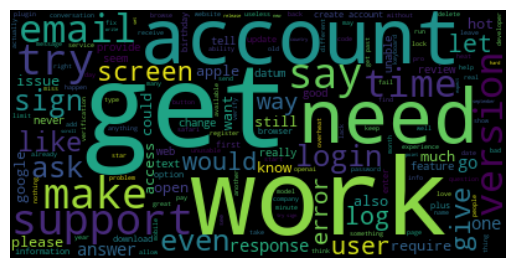

In [39]:
#Negative Setiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in negative.complete_review)
wordcloud = WordCloud(stopwords=stopword).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

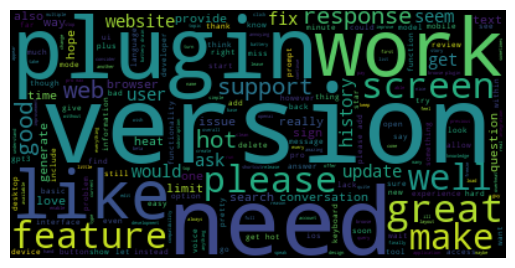

In [40]:
#Neutral Sentiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in neutral.complete_review)
wordcloud = WordCloud(stopwords=stopword).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## **Sentiment Analysis Model**

#### **Bag of Word Vectorization**

In [41]:
#from nltk.tokenize import RegexpTokenizer
#from sklearn.feature_extraction.text import CountVectorizer

In [42]:
# Pre-Prcoessing and Bag of Word Vectorization using Count Vectorizer
#token = RegexpTokenizer(r'[a-zA-Z0-9]+')
#cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
#X = cv.fit_transform(data['complete_review'])
#y = data['sentiment']

#### **Handle Imbalanced Data**

In [43]:
#from imblearn.over_sampling import SMOTE

In [44]:
# Instantiate the SMOTE object
#smote = SMOTE()

# Perform oversampling
#X_oversampled, y_oversampled = smote.fit_resample(X, y)

#### **Train Test Split**

In [45]:
from sklearn.model_selection import train_test_split

#Train Test split
X_train, X_test, y_train, y_test = train_test_split(data['complete_review'],
                                                   data['sentiment'],
                                                   test_size=0.15,
                                                   random_state=42,
                                                   stratify=data['sentiment'])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1749,)
(309,)
(1749,)
(309,)


## **Split data into training and validation sets**

In [46]:
## Changed to data, we can aslo data['somplete_review'] or data['sentiment']

# Shuffle training dataframe
train_df_shuffled = data.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,rating,complete_review,sentiment
1298,1,log apple account log official website can not...,0
591,4,first message ios store well must say first ve...,2
1318,5,truthgpt elon musk sam altman truthgpt also go...,2
1067,4,30 great issue do not knowledge past september...,2
29,5,cuttingedge conversation pocket write gamechan...,2


In [47]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df_shuffled)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["complete_review", "sentiment"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"sentiment: {target}", "(Negative)" if target == 0 else "(Neutral)" if target == 1 else "(Positive)")
  print(f"complete_review:\n{text}\n")
  print("---\n")

sentiment: 2 (Positive)
complete_review:
great good discovery year pity block belarus

---

sentiment: 0 (Negative)
complete_review:
keyboard login try log google account can not keyboard display focus input email address field

---

sentiment: 1 (Neutral)
complete_review:
delete button need work press delete remove prompt history first time do not work delete second attempt yay persistence

---

sentiment: 1 (Neutral)
complete_review:
great llm mid ethic great way communicate model get relevant information poor mid try create moat require license build openai opensource

---

sentiment: 2 (Positive)
complete_review:
big wowza significant time exceptional prowess leave thoroughly wow

---



In [48]:
train_df_shuffled["complete_review"].shape

(2058,)

In [49]:
## Changed train_df_shuffled["complete_review"] and train_df_shuffled["sentiment"]

from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["complete_review"].to_numpy(),
                                                                            train_df_shuffled["sentiment"].to_numpy(),
                                                                            test_size=0.20, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [50]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(1646, 1646, 412, 412)

In [51]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['super fast free much fast plane desktop hope stay way',
        'gpt3 4 4', 'unavailable oop run issue authenticating',
        'good good', 'scam do not enter login info email',
        'ease excellent leery instead go openai site sometimes thing do not work well even well thank',
        'nice simple easy free subscription require headache induce color tab',
        'agenda propaganda ask kind woman might good wife rather tell base agree upon characteristic choose lecture gender software engineer need go jail I m tired blatant agenda claim ignorance call software engineer trash proof',
        'make well place make world well place',
        'finally tablet create shortcut open web browser simulate much convenient already pay plus subscription do not want pay separate openai api anyways'],
       dtype=object),
 array([2, 2, 0, 2, 0, 2, 2, 0, 2, 2], dtype=int64))

## **Converting text into numbers (tokenization)**

In [52]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization # after TensorFlow 2.6

# Before TensorFlow 2.6
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization 
# Note: in TensorFlow 2.6+, you no longer need "layers.experimental.preprocessing"
# you can use: "tf.keras.layers.TextVectorization", see https://github.com/tensorflow/tensorflow/releases/tag/v2.6.0 for more

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [53]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

21

In [54]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 21 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)


In [55]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [56]:
# Create sample sentence and tokenize it
sample_sentence = "Amazing, I like ChatGPT app!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 21), dtype=int64, numpy=
array([[34,  3,  4,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0]], dtype=int64)>

In [57]:
# Choose a random sentence from the training dataset and tokenize it
import random
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
nice wait since inception thank openai      

Vectorized version:


<tf.Tensor: shape=(1, 21), dtype=int64, numpy=
array([[  68,  116,  281, 3834,   45,   29,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int64)>

In [58]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 4830
Top 5 most common words: ['', '[UNK]', 'not', 'i', 'like']
Bottom 5 least common words: ['156', '14pro', '14pm', '1020', '0']


## **Creating an Embedding using an Embedding Layer**

In [59]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

embedding

In [60]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
please automatically translate voice recording question please translate voice recorder question automatically leave wonderful functionality voice recording multi language capability      

Embedded version:


<tf.Tensor: shape=(1, 21, 128), dtype=float32, numpy=
array([[[ 0.04355836,  0.00965116,  0.01327338, ..., -0.01551508,
         -0.01379405, -0.00955128],
        [-0.00819826, -0.04932213, -0.02674487, ...,  0.01359303,
         -0.03781599,  0.03049994],
        [-0.039104  ,  0.04832449, -0.04879514, ...,  0.01807867,
          0.04260483,  0.01154967],
        ...,
        [ 0.03956235, -0.02400222,  0.01236161, ..., -0.02026143,
         -0.03520912,  0.046888  ],
        [ 0.04222994,  0.04523207, -0.03295344, ..., -0.03162105,
         -0.03003605,  0.02776458],
        [-0.0273085 ,  0.01835593,  0.04483062, ...,  0.04385355,
          0.03745553,  0.04756625]]], dtype=float32)>

In [61]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.04355836,  0.00965116,  0.01327338, -0.03016484, -0.00537422,
       -0.01704557, -0.01430842, -0.03310641, -0.00948085, -0.0067104 ,
        0.0352465 ,  0.01803173,  0.03057433, -0.04887066, -0.04521288,
       -0.0381336 , -0.03449917,  0.0047516 ,  0.04608805, -0.01288559,
        0.02164009, -0.04495156, -0.04756842, -0.00200795, -0.02262002,
        0.03756749,  0.01542831, -0.01709678,  0.02601537, -0.04597373,
       -0.03433901,  0.02704186, -0.02852302,  0.0258409 ,  0.04546065,
       -0.02000757,  0.04548891, -0.03022262,  0.00218824, -0.01259305,
        0.00762777, -0.03687019,  0.03107537,  0.02124145, -0.01923492,
       -0.00973701, -0.00778659, -0.0337306 , -0.04723374,  0.01005576,
       -0.00902013, -0.00236827, -0.02557826,  0.01777506,  0.0307487 ,
       -0.01376897,  0.04454513,  0.03326774,  0.04134541,  0.01326587,
       -0.00451908,  0.03563387, -0.01397183,  0.04539039,  0.01877916,
       -0.045537

## **Modelling a text dataset**

* **Model 0**: Naive Bayes (baseline)
* **Model 1**: Feed-forward neural network (dense model)
* **Model 2**: LSTM model
* **Model 3**: GRU model
* **Model 4**: Bidirectional-LSTM model
* **Model 5**: 1D Convolutional Neural Network
* **Model 6**: TensorFlow Hub Pretrained Feature Extractor
* **Model 7**: Same as model 6 with 10% of training data

#### Model 0: Getting a baseline

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
#model_0.fit(train_sentences, train_labels)
model_0.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [63]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 73.79%


In [64]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=int64)

## **Creating an evaluation function for our model experiments**

* Accuracy
* Precision
* Recall
* F1-score

In [65]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [66]:
baseline_preds.shape

(412,)

In [67]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 73.7864077669903,
 'precision': 0.6886516802078706,
 'recall': 0.7378640776699029,
 'f1': 0.6787470222202547}

#### Model 1: A simple dense model

In [68]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [69]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [70]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                #optimizer = 'rmsprop',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [71]:
# Get a summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 21)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 21, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [72]:
# Fit the model
model_1_history = model_1.fit(#train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              #train_labels,
                              X_train,
                              y_train,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20230722-163126
Epoch 1/5
55/55 [==============================] - 1s 11ms/step - loss: 0.4027 - accuracy: 0.0989 - val_loss: 0.0937 - val_accuracy: 0.1092
Epoch 2/5
55/55 [==============================] - 1s 9ms/step - loss: -0.3943 - accuracy: 0.0978 - val_loss: -0.7728 - val_accuracy: 0.1092
Epoch 3/5
55/55 [==============================] - 0s 9ms/step - loss: -1.4860 - accuracy: 0.0983 - val_loss: -1.8770 - val_accuracy: 0.1092
Epoch 4/5
55/55 [==============================] - 0s 9ms/step - loss: -2.9335 - accuracy: 0.1006 - val_loss: -3.3476 - val_accuracy: 0.1117
Epoch 5/5
55/55 [==============================] - 0s 9ms/step - loss: -4.9214 - accuracy: 0.1035 - val_loss: -5.3259 - val_accuracy: 0.1141


In [73]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

13/13 [==============================] - 0s 1ms/step - loss: -5.3259 - accuracy: 0.1141


[-5.325896739959717, 0.11407767236232758]

In [74]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[-0.35741758, -0.35496154, -0.25634062, ..., -0.30780044,
         -0.24545558, -0.23596644],
        [-0.05094228, -0.0738013 , -0.07946575, ..., -0.10880508,
         -0.12215096, -0.08743235],
        [ 0.06294343,  0.02436891,  0.04837132, ...,  0.0656468 ,
          0.05620174,  0.04399661],
        ...,
        [ 0.04818587,  0.03340283,  0.03635751, ...,  0.01869125,
         -0.02082245, -0.04073659],
        [-0.00325979, -0.03637518,  0.01154517, ...,  0.02600462,
          0.04880026, -0.01176232],
        [-0.00702084,  0.03931394, -0.02017345, ..., -0.02366207,
          0.03397298, -0.01384647]], dtype=float32)>]

In [75]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [76]:
## View tensorboard logs of transfer learning modelling experiments (should be 4 models)
## Upload TensorBoard dev records
#!tensorboard --version
#!tensorboard dev upload --logdir ./model_logs \
#--name "First deep model on text data" \
#--description "Trying a dense model with an embedding layer" \
#--one_shot # exits the uploader when upload has finished

In [77]:
# If you need to remove previous experiments, you can do so using the following command
# !tensorboard dev delete --experiment_id EXPERIMENT_ID_TO_DELETE

In [78]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10] # only print out the first 10 prediction probabilities

13/13 [==============================] - 0s 918us/step


array([[0.9999998],
       [0.907441 ],
       [0.9999997],
       [0.9995574],
       [0.9999996],
       [0.9997825],
       [1.       ],
       [0.9999971],
       [1.       ],
       [0.9898986]], dtype=float32)

In [79]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_pred_probs[:20]

array([[0.9999998 ],
       [0.907441  ],
       [0.9999997 ],
       [0.9995574 ],
       [0.9999996 ],
       [0.9997825 ],
       [1.        ],
       [0.9999971 ],
       [1.        ],
       [0.9898986 ],
       [0.9999999 ],
       [0.999998  ],
       [0.9999998 ],
       [0.9999999 ],
       [0.99997056],
       [0.99999994],
       [0.9995604 ],
       [0.99956465],
       [0.99830675],
       [0.9999822 ]], dtype=float32)

In [80]:
model_1_preds.shape

TensorShape([412])

In [81]:
# Need to change from TensorShape to numpy array 
model_1_preds_numpy = model_1_preds.numpy()

In [82]:
model_1_preds_numpy.shape

(412,)

In [83]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds_numpy)
model_1_results

{'accuracy': 11.407766990291263,
 'precision': 0.29111413686952403,
 'recall': 0.11407766990291263,
 'f1': 0.031147385516317558}

In [84]:
# Is our simple Keras model better than our baseline model?
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [85]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_1_results)

Baseline accuracy: 73.79, New accuracy: 11.41, Difference: -62.38
Baseline precision: 0.69, New precision: 0.29, Difference: -0.40
Baseline recall: 0.74, New recall: 0.11, Difference: -0.62
Baseline f1: 0.68, New f1: 0.03, Difference: -0.65


#### Recurrent Neural Networks (RNN's)

#### Model 2: LSTM

In [86]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 21, 128)
(None, 64)


In [87]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [88]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 21)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 21, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [89]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20230722-163130
Epoch 1/5
52/52 [==============================] - 2s 17ms/step - loss: -2.4084 - accuracy: 0.0930 - val_loss: -3.7170 - val_accuracy: 0.1092
Epoch 2/5
52/52 [==============================] - 1s 11ms/step - loss: -6.1253 - accuracy: 0.1173 - val_loss: -6.2379 - val_accuracy: 0.1917
Epoch 3/5
52/52 [==============================] - 1s 12ms/step - loss: -8.9494 - accuracy: 0.2023 - val_loss: -7.7282 - val_accuracy: 0.2209
Epoch 4/5
52/52 [==============================] - 1s 11ms/step - loss: -11.4127 - accuracy: 0.2266 - val_loss: -9.4209 - val_accuracy: 0.2306
Epoch 5/5
52/52 [==============================] - 1s 11ms/step - loss: -13.6720 - accuracy: 0.2309 - val_loss: -10.7965 - val_accuracy: 0.2282


In [90]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

13/13 [==============================] - 0s 2ms/step


((412, 1),
 array([[1.        ],
        [0.0116844 ],
        [0.00326053],
        [0.00269602],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [0.0052258 ]], dtype=float32))

In [91]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 0., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [92]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 22.815533980582526,
 'precision': 0.18670182972367438,
 'recall': 0.22815533980582525,
 'f1': 0.1825496963291977}

In [93]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 73.79, New accuracy: 22.82, Difference: -50.97
Baseline precision: 0.69, New precision: 0.19, Difference: -0.50
Baseline recall: 0.74, New recall: 0.23, Difference: -0.51
Baseline f1: 0.68, New f1: 0.18, Difference: -0.50


#### Model 3: GRU

In [94]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x) 
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [95]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [96]:
# Get a summary of the GRU model
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 21)                0         
 Vectorization)                                                  
                                                                 
 embedding_3 (Embedding)     (None, 21, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [97]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20230722-163135
Epoch 1/5
52/52 [==============================] - 2s 16ms/step - loss: -2.1664 - accuracy: 0.0936 - val_loss: -3.7585 - val_accuracy: 0.1092
Epoch 2/5
52/52 [==============================] - 1s 11ms/step - loss: -5.7472 - accuracy: 0.0936 - val_loss: -5.0778 - val_accuracy: 0.1092
Epoch 3/5
52/52 [==============================] - 1s 11ms/step - loss: -7.3376 - accuracy: 0.0936 - val_loss: -6.2801 - val_accuracy: 0.1092
Epoch 4/5
52/52 [==============================] - 1s 10ms/step - loss: -8.8432 - accuracy: 0.0936 - val_loss: -7.3931 - val_accuracy: 0.1092
Epoch 5/5
52/52 [==============================] - 1s 11ms/step - loss: -10.3106 - accuracy: 0.0936 - val_loss: -8.5053 - val_accuracy: 0.1092


In [98]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

13/13 [==============================] - 0s 2ms/step


((412, 1),
 array([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], dtype=float32))

In [99]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>

In [100]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 10.922330097087379,
 'precision': 0.011929729474974077,
 'recall': 0.10922330097087378,
 'f1': 0.021510059272163325}

In [101]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 73.79, New accuracy: 10.92, Difference: -62.86
Baseline precision: 0.69, New precision: 0.01, Difference: -0.68
Baseline recall: 0.74, New recall: 0.11, Difference: -0.63
Baseline f1: 0.68, New f1: 0.02, Difference: -0.66


#### Model 4: Bidirectonal RNN model

#### **Multinomial Naive Bayes**

In [102]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report

In [103]:
#Training the model
MNB = MultinomialNB()
MNB.fit(X_train, y_train)

#Caluclating the accuracy score of the model
y_pred = MNB.predict(X_test)
print(classification_report(y_pred, y_test))

ValueError: could not convert string to float: ''

#### **Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
print(classification_report(y_pred, y_test))

#### **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Initialize and train the random forest classifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
print(classification_report(y_pred, y_test))

#### **XGBoost**

In [ ]:
import xgboost as xgb

In [ ]:
# Create DMatrix for training and testing data
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set the parameters for XGBoost
params = {
    'objective': 'multi:softmax',  # Set the objective function for multi-class classification
    'num_class': 3,      # Number of classes in the dataset
    'eval_metric': 'merror',        # Evaluation metric (multi-class classification error rate)
    'eta': 0.4,                    # Learning rate
    'max_depth': 6,                # Maximum depth of a tree
    'subsample': 0.8,              # Subsample ratio of the training instances
    'colsample_bytree': 0.8,       # Subsample ratio of features when constructing each tree
    'seed': 42                     # Random seed for reproducibility
}

# Train the XGBoost model
num_rounds = 100  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the testing data
preds = model.predict(dtest)
pred_labels = [int(pred) for pred in preds]

print(classification_report(pred_labels, y_test))



In [ ]:
# Create DMatrix for training and testing data
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set the parameters for XGBoost
params = {
    'objective': 'multi:softmax',  # Set the objective function for multi-class classification
    'num_class': 3,      # Number of classes in the dataset
    'eval_metric': 'merror',        # Evaluation metric (multi-class classification error rate)
    'eta': 0.4,                    # Learning rate
    'max_depth': 6,                # Maximum depth of a tree
    'subsample': 0.8,              # Subsample ratio of the training instances
    'colsample_bytree': 0.8,       # Subsample ratio of features when constructing each tree
    'seed': 42                     # Random seed for reproducibility
}

# Train the XGBoost model
num_rounds = 100  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the testing data
preds = model.predict(dtest)
pred_labels = [int(pred) for pred in preds]

print(classification_report(pred_labels, y_test))